In [1]:
import matplotlib.pyplot as plt
import mplhep
import numpy as np
import pandas as pd
import scipy.optimize as sc
import scipy

**1. Calibration**

In [2]:
file_Hg_calib = 'CCD/Hg_calibration_1.txt'

Hg_cal = pd.read_csv(file_Hg_calib, skiprows=17, skipfooter=1, sep='\t',
                     names=['Channel', 'Counts'], decimal=',', engine = 'python')

In [3]:
def lorentz(x, A, w0, gamma):
    '''Function of a Lorentz-curve.

    w0 : position of maximum
    gamma : curve width
    '''
    return A/((x**2 - w0**2)**2 + gamma**2 * w0**2)


def voigt(x, mean, sigma, gamma, A, c):
    return A * scipy.special.voigt_profile(x-mean, sigma, gamma) + c


def gauss(x, A, mu, sigma, C):
    return A * np.exp(-(x-mu)**2 / (2*sigma)) + C


def linear(x, a, b):
    return a * x + b

[2.81177052e+04 4.35409725e+02 1.27182753e-01 1.76300124e+03] [1.16445871e+03 1.45400611e-02 1.43231363e-02 8.11668031e+02]
[ 9.04077146e+04  5.45825849e+02  2.72321122e-01 -2.56502266e+04] [1.47411478e+04 1.33901800e-02 8.23035654e-02 1.57060727e+04]
[ 1.59907848e+04  5.76706504e+02  1.08681270e-01 -1.68277919e+03] [6.92763682e+02 3.85779547e-03 1.02878220e-02 7.55603777e+02]
[ 1.58508401e+04  5.78813581e+02  1.03740745e-01 -1.46356251e+03] [6.06614212e+02 3.99389152e-03 8.96688442e-03 6.60566544e+02]


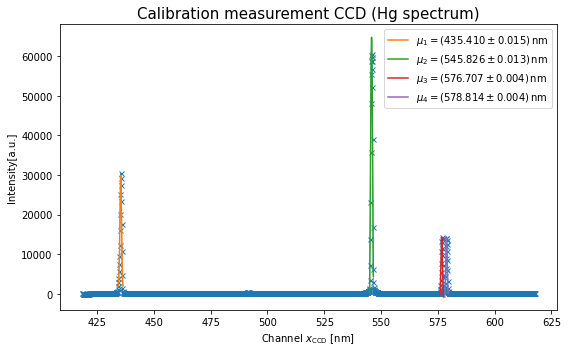

In [4]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(Hg_cal['Channel'], Hg_cal['Counts'], marker = 'x', lw=0.5, ms = 5)
coefficients = np.zeros((4, 4))
covariance = np.zeros((4, 4, 4))
arg0 = 0
arg1=True
a = [[132, 153], [1185, 1204], [1530, 1545], [1555, 1570]]
p0s = [[30000, 435, 1, 0], [60000, 546, 1, 0], [15000, 577, 1, 0], [15000, 579, 1, 0]]
xaxis = [np.linspace(434, 436.5 ,1001), np.linspace(545, 546.6, 1001), np.linspace(576,577.5,1001), np.linspace(578, 579.5, 1001)]
colors = ['C1', 'C2', 'C3', 'C4']
for i in range(4):
    params, cov = sc.curve_fit(gauss, Hg_cal['Channel'][a[i][0]:a[i][1]], Hg_cal['Counts'][a[i][0]:a[i][1]],
                              p0 = p0s[i])
    coefficients[i] = params
    covariance[i] = cov
    print(params, np.sqrt(np.diag(cov)))
    if arg0:
        ax.axvline(Hg_cal['Channel'][a[i][0]], color=colors[i], ls='--', lw=1)
        ax.axvline(Hg_cal['Channel'][a[i][1]], color=colors[i], ls='--', lw=1)
    if arg1:
        ax.plot(xaxis[i], gauss(xaxis[i], *params), color=colors[i], label = r'$\mu_{} = ({:.3f} \pm {:.3f})\,$nm'.format(i+1, params[1], np.sqrt(cov[1,1])))

ax.set_xlabel(r'Channel $x_\mathrm{CCD}$ [nm]')
ax.set_ylabel(r'Intensity[a.u.]')
ax.set_title(r'Calibration measurement CCD (Hg spectrum)', size = 15)
ax.legend()
# ax.set_xlim([430, 440])  # show the first peak
# ax.set_xlim([542, 550])  # second peak
# ax.set_xlim([575, 580])
plt.tight_layout()
# plt.savefig('Figures/Calibration_CCD.pdf')
plt.show()

[0.99876846 0.95205937] [[ 5.12353155e-08 -2.73693766e-05]
 [-2.73693766e-05  1.47958210e-02]] [0.00022635 0.12163807]


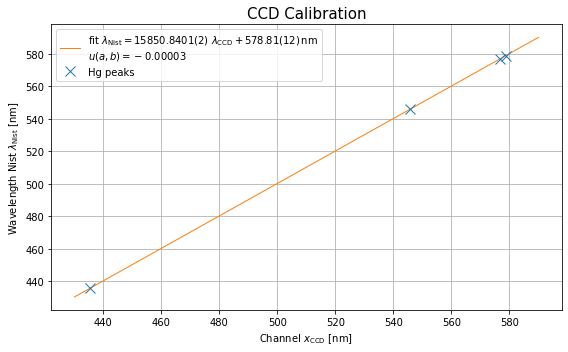

In [5]:
Hg_Nist = [435.8328, 546.0735, 576.9598, 579.0663]
params_linear, cov_linear = sc.curve_fit(linear, coefficients[:,1], Hg_Nist)
print(params_linear,cov_linear, np.sqrt(np.diagonal(cov_linear)))
channels = np.linspace(430, 590, 1001)
fig, ax = plt.subplots(figsize=(8,5))
ax.errorbar(coefficients[:,1], Hg_Nist, marker = 'x', lw = 0, ms=10, label = r'Hg peaks')
ax.plot(channels, linear(channels, *params_linear), marker = None, lw=1,
        label = r'fit $\lambda_\mathrm{{Nist}} = {:.4f}(2)~\lambda_\mathrm{{CCD}} + {:.2f}(12)\,$nm'.format(
            params[0], params[1]) + '\n' + r'$u(a,b) = {:.5f}$'.format(cov_linear[0,1]))
ax.set_xlabel(r'Channel $x_\mathrm{CCD}$ [nm]')
ax.set_ylabel(r'Wavelength Nist $\lambda_\mathrm{Nist}$ [nm]')
ax.set_title(r'CCD Calibration', size=15)
ax.grid()
ax.legend()
plt.tight_layout()
# plt.savefig('Figures/Calibration_line_CCD.pdf', dpi=600)
plt.show()

In [6]:
Hg_Nist = [435.8328, 546.0735, 576.9598, 579.0663]
for i in range(4):
    print('Fit:', coefficients[i,1], r'+-', np.sqrt(covariance[i,1,1]))
    print('Nist', Hg_Nist[i])
print('\n Our CCD is slightly (approx 0.2nm) shifted down.')

Fit: 435.4097253968394 +- 0.014540061084557942
Nist 435.8328
Fit: 545.8258491117172 +- 0.013390180001561345
Nist 546.0735
Fit: 576.7065044754747 +- 0.0038577954665836626
Nist 576.9598
Fit: 578.8135808545674 +- 0.003993891521947161
Nist 579.0663

 Our CCD is slightly (approx 0.2nm) shifted down.


**2. Laser wavelength determination**

In [7]:
file_laser = 'CCD/laser_spectrum.txt'

laser = pd.read_csv(file_laser, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'], decimal=',', engine='python')

[7.23876640e+04 5.31817984e+02 9.65111944e-02 1.49149154e+02] $\pm$ [2.58378223e+02 7.65268511e-04 5.68372354e-04 6.34774160e+00]


<ipython-input-3-7d357bd15ccf>:15: RuntimeWarning: overflow encountered in exp
  return A * np.exp(-(x-mu)**2 / (2*sigma)) + C
<ipython-input-3-7d357bd15ccf>:15: RuntimeWarning: overflow encountered in multiply
  return A * np.exp(-(x-mu)**2 / (2*sigma)) + C


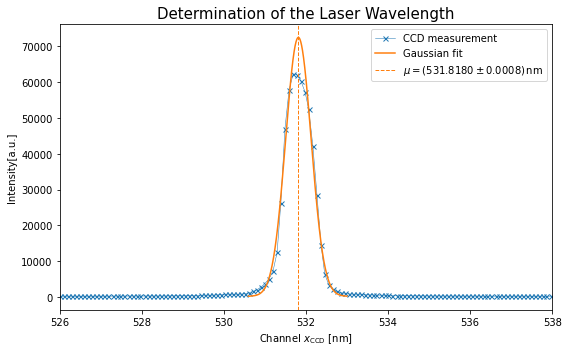

In [8]:
# exclude 1046, 1047, 1048 from fit as the CCD saturated here

xfit = np.concatenate((np.array(laser['Channel'][:1046]), np.array(laser['Channel'][1049:])))
yfit = np.concatenate((np.array(laser['Counts'][:1046]), np.array(laser['Counts'][1049:])))

par_laser, cov_laser = sc.curve_fit(gauss, xfit, yfit, p0=[60000, 532, 10, 20])
print(par_laser, r'$\pm$', np.sqrt(np.diag(cov_laser)))
xaxis = np.linspace(530.6, 533, 1001)
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(laser['Channel'], laser['Counts'], marker = 'x', lw=0.5, ms = 5, label = 'CCD measurement')

ax.plot(xaxis, gauss(xaxis, *par_laser), color = colors[0], label = 'Gaussian fit')
ax.axvline(par_laser[1], lw = 1, ls = '--', color = colors[0], label = r'$\mu = ({:.4f} \pm {:.4f})\,$nm'.format(par_laser[1], np.sqrt(cov_laser[1,1])))

ax.set_xlim(526, 538)
ax.legend()
ax.set_xlabel(r'Channel $x_\mathrm{CCD}$ [nm]')
ax.set_ylabel(r'Intensity[a.u.]')
ax.set_title(r'Determination of the Laser Wavelength', size = 15)
plt.tight_layout()
# plt.savefig('Figures/Laserwavelength.pdf', dpi=800)
plt.show()

In [9]:
c_a, c_b = params_linear
u_c_a, u_c_b = np.sqrt(np.diagonal(cov_linear))
def wave(lamb, u_lamb):
    w = lamb * c_a + c_b
    u_w = np.sqrt((lamb * u_c_a)**2 + (u_c_b)**2 + (c_a * u_lamb)**2)
    return w, u_w
print(par_laser[1], np.sqrt(cov_laser[1,1]))
print(wave(par_laser[1], np.sqrt(cov_laser[1,1])))

531.8179838362893 0.000765268511498869
(532.1150887716177, 0.17113535083272308)


In [10]:
out = pd.DataFrame({'params_linear':params_linear,
                    'cov_linear': np.sqrt(np.diagonal(cov_linear)),
                    'laser':par_laser[1], 
                    'u_laser':np.sqrt(cov_laser[1,1]),
                    'laser_corr': wave(par_laser[1], np.sqrt(cov_laser[1,1]))})

out.to_csv('CCD_params.csv', index=False)

In [11]:
file_1 = 'CCD/white_light_1.txt'
file_2 = 'CCD/white_light_notch_1.txt'

df_white = pd.read_csv(file_1, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'],
                       decimal=',', engine='python')
df_white_notch = pd.read_csv(file_2, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'],
                             decimal=',', engine='python')

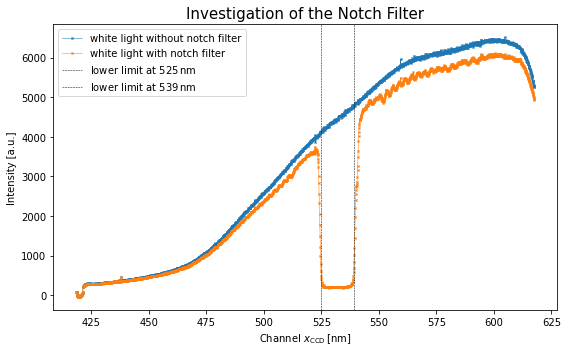

In [12]:
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(df_white['Channel'], df_white['Counts'], marker = 'x', lw=0.5, ms = 2, label = 'white light without notch filter', color = 'C0')
ax.plot(df_white_notch['Channel'], df_white_notch['Counts'], marker = 'x', lw=0.5, ms = 2, label= 'white light with notch filter', color = 'C1')
ax.axvline(525, ls='--', lw=0.5, color='black', label = 'lower limit at $525\,$nm')
ax.axvline(539, ls='--', lw=0.5, color='black', label = 'lower limit at $539\,$nm')
ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_title(r'Investigation of the Notch Filter', size=15)
# ax.set_xlim(538, 542)
ax.legend()
plt.tight_layout()
# plt.savefig('Figures/Notchfilter.pdf', dpi=800)
plt.show()

In [13]:
file_1 = 'CCD/white_light_0degree.txt'
file_2 = 'CCD/white_light_90degree.txt'

df0 = pd.read_csv(file_1, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'],
                       decimal=',', engine='python')
df90 = pd.read_csv(file_2, skiprows=17, skipfooter=1, sep='\t', names=['Channel', 'Counts'],
                             decimal=',', engine='python')

[ 2.16383690e-10 -5.88004939e-07  6.37366653e-04 -3.44410429e-01
  9.27549607e+01 -9.95641290e+03] [4.83227351e-12 1.32965930e-08 1.46237180e-05 8.03549900e-03
 2.20599598e+00 2.42059831e+02] [ 0.02233197 -0.02261306  0.02294396 -0.02333117  0.02378305 -0.02431195]


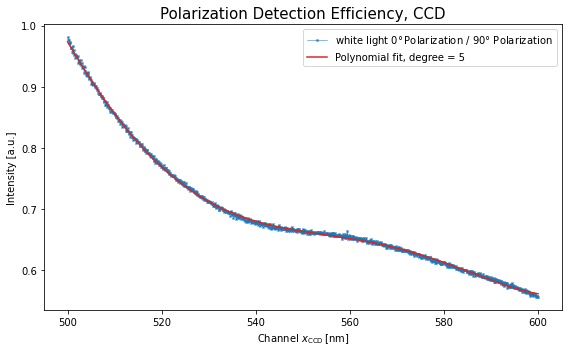

In [58]:
x0, y0 = df0['Channel'][732:1818], df0['Counts'][732:1818]
x90, y90 = df90['Channel'][732:1818], df90['Counts'][732:1818]

lin_par, lin_cov = np.polyfit(x0, y0/y90, 5, rcond=None, full=False, w=None, cov=True)

print(lin_par, np.sqrt(np.diagonal(lin_cov)), np.sqrt(np.diagonal(lin_cov)) / lin_par)

xaxis = np.linspace(500, 600, 1001)

fig, ax = plt.subplots(figsize = (8,5))
# ax.plot(x0, y0, marker = 'x', lw=0.5, ms = 2, label = r'white light $0\degree$ Polarization filter', color = 'C0')
# ax.plot(x0, y0, marker = 'x', lw=0.5, ms = 2, label= r'white light $90\degree$ Polarization filter', color = 'C1')
ax.plot(x0, y0/y90, marker = 'x', lw=0.5, ms = 2, label= r'white light $0\degree\,$Polarization / $90\degree$ Polarization', color = 'C0')
ax.plot(xaxis, np.polyval(lin_par, xaxis), color = 'C3', label ='Polynomial fit, degree = 5')
ax.set_xlabel(r'Channel $x_\mathrm{CCD}\,$[nm]')
ax.set_ylabel(r'Intensity [a.u.]')
ax.set_title(r'Polarization Detection Efficiency, CCD', size=15)
ax.legend()
plt.tight_layout()
# plt.savefig('Figures/Notchfilter.pdf', dpi=800)
plt.show()
